In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

# Load dataset
data = pd.read_csv('Cleaned_MCS_TEAM_DATA.csv')

# Convert DATETIME to datetime object
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# Sort dataset by date just to be sure
data = data.sort_values(by='DATETIME')

# Handle categorical data
# Encode 'ACTUAL CONDITION' and 'OCCURRENCE OF FLOOD'
le_condition = LabelEncoder()
le_flood = LabelEncoder()

data['ACTUAL CONDITION'] = le_condition.fit_transform(data['ACTUAL CONDITION'])
data['OCCURENCE OF FLOOD'] = le_flood.fit_transform(data['OCCURENCE OF FLOOD'])

# Features and Target Columns
features = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']
target_columns = features

# Scale features (0, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Prepare Time Series Data
look_back = 21  # Number of time steps to look back (7 days * 3 readings/day)

# Using TimeseriesGenerator to create batches of time series data for LSTM
X = scaled_data
y = scaled_data  # Predicting multiple features

generator = TimeseriesGenerator(X, y, length=look_back, batch_size=32)

# Define the LSTM Model
model = Sequential()
model.add(LSTM(250, activation='relu', input_shape=(look_back, len(features)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(features)))  # Output layer with multiple features

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(generator, epochs=70)

# Forecast the next 7 days (7 * 3 = 21 predictions since each day has 3 readings)
n_future = 21  # Predicting 21 steps ahead (7 days of 3 readings per day)
last_data = scaled_data[-look_back:]  # Take the last 'look_back' period to predict

# Generate predictions for next 7 days
forecast = []
input_seq = last_data.reshape((1, look_back, len(features)))

for _ in range(n_future):
    prediction = model.predict(input_seq)
    forecast.append(prediction[0])
    # Update the input sequence with the new prediction
    input_seq = np.append(input_seq[:, 1:, :], [[prediction[0]]], axis=1)

# Convert forecast back to original scale
forecast = scaler.inverse_transform(forecast)

# Create a dataframe for the forecasted data
forecast_dates = pd.date_range(start=data['DATETIME'].max() + pd.Timedelta(hours=8), periods=n_future, freq='8H')
forecast_df = pd.DataFrame(forecast, columns=features)
forecast_df['DATETIME'] = forecast_dates

# Decode categorical values back to original form
forecast_df['ACTUAL CONDITION'] = le_condition.inverse_transform(forecast_df['ACTUAL CONDITION'].astype(int))
forecast_df['OCCURENCE OF FLOOD'] = le_flood.inverse_transform(forecast_df['OCCURENCE OF FLOOD'].astype(int))

# Display the forecast
print(forecast_df[['DATETIME', 'TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']])


Epoch 1/70


2024-10-16 14:36:33.814752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 3s 35ms/step - loss: 0.0693
Epoch 2/70
57/57 [==============================] - 2s 37ms/step - loss: 0.0377
Epoch 3/70
57/57 [==============================] - 2s 38ms/step - loss: 0.0372
Epoch 4/70
57/57 [==============================] - 2s 38ms/step - loss: 0.0363
Epoch 5/70
57/57 [==============================] - 2s 38ms/step - loss: 0.0368
Epoch 6/70
57/57 [==============================] - 2s 38ms/step - loss: 0.0358
Epoch 7/70
57/57 [==============================] - 2s 38ms/step - loss: 0.0347
Epoch 8/70
57/57 [==============================] - 2s 38ms/step - loss: 0.0347
Epoch 9/70
57/57 [==============================] - 2s 40ms/step - loss: 0.0346
Epoch 10/70
57/57 [==============================] - 2s 38ms/step - loss: 0.0341
Epoch 11/70
57/57 [==============================] - 2s 38ms/step - loss: 0.0341
Epoch 12/70
57/57 [==============================] - 2s 38ms/step - loss: 0.0342
Epoch 13/70
57/57 [=============================

/var/folders/j3/kwprsg3s3_zf9_90gxwcknm00000gn/T/ipykernel_68698/3078527254.py:74: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_dates = pd.date_range(start=data['DATETIME'].max() + pd.Timedelta(hours=8), periods=n_future, freq='8H')


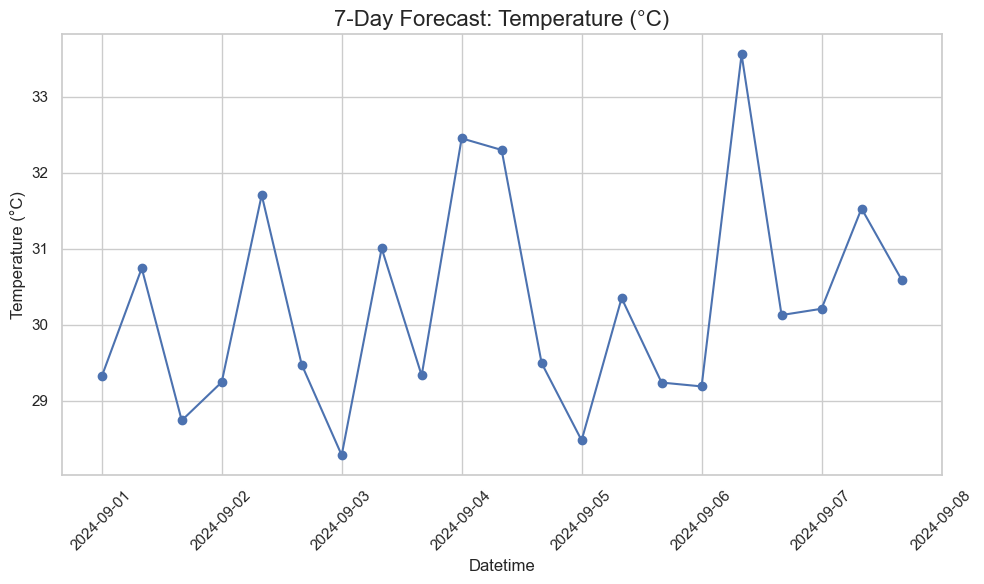

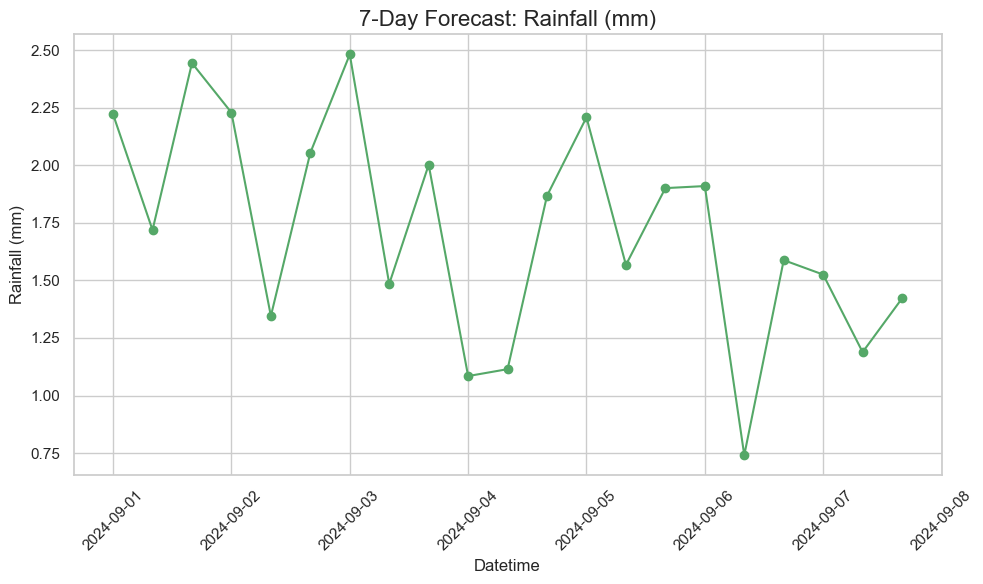

Index(['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION',
       'OCCURENCE OF FLOOD', 'DATETIME'],
      dtype='object')


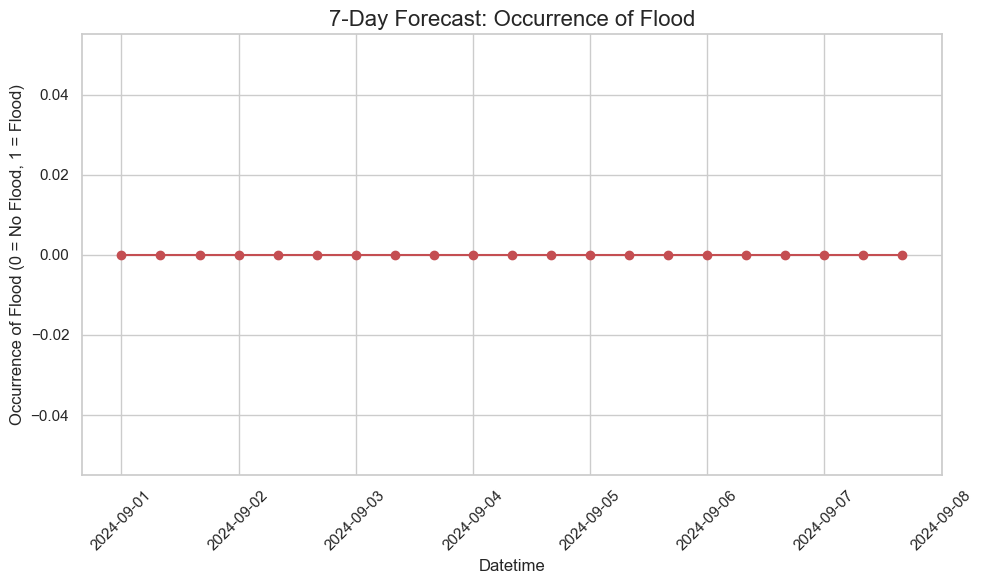

             DATETIME  ACTUAL CONDITION  OCCURENCE OF FLOOD
0 2024-09-01 00:00:00                 2                   0
1 2024-09-01 08:00:00                 2                   0
2 2024-09-01 16:00:00                 2                   0
3 2024-09-02 00:00:00                 2                   0
4 2024-09-02 08:00:00                 2                   0


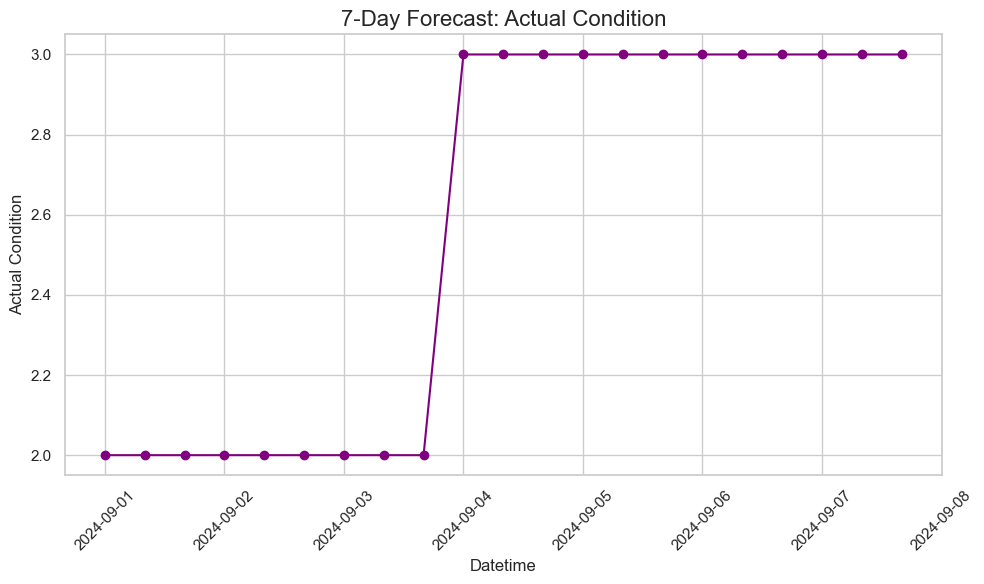

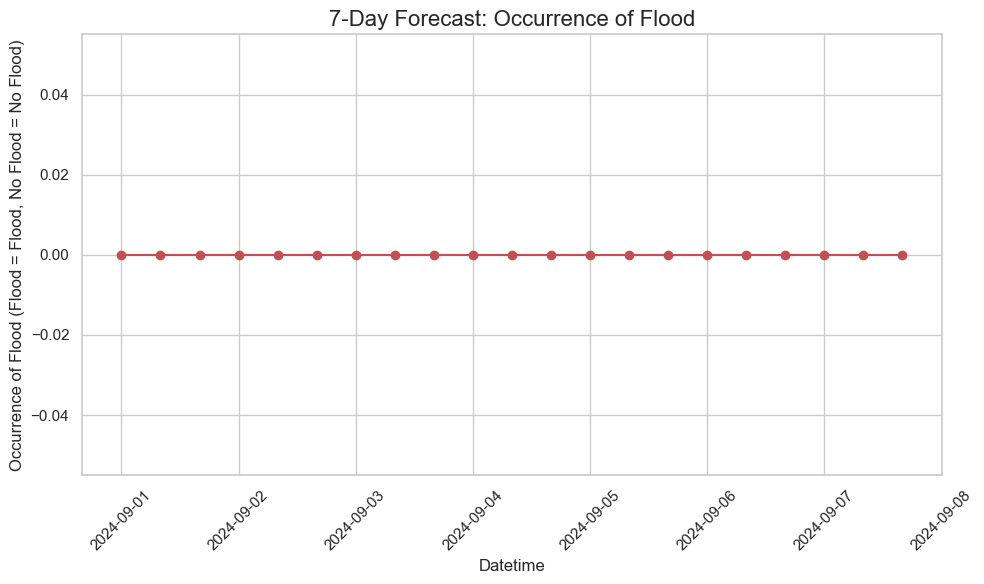

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Forecast dataframe already created
# forecast_df[['DATETIME', 'TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURRENCE OF FLOOD']]

# Set the style for the plots
sns.set(style='whitegrid')

# Plot 'TEMPERATURE (°C)'
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['DATETIME'], forecast_df['TEMPERATURE (°C)'], marker='o', color='b')
plt.title('7-Day Forecast: Temperature (°C)', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 'RAINFALL (mm)'
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['DATETIME'], forecast_df['RAINFALL (mm)'], marker='o', color='g')
plt.title('7-Day Forecast: Rainfall (mm)', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Rainfall (mm)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print column names to verify
print(forecast_df.columns)

# Adjust the plotting code based on the correct column name

# Plot 'OCCURRENCE OF FLOOD' (check for correct column name in the DataFrame)
if 'OCCURENCE OF FLOOD' in forecast_df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_df['DATETIME'], forecast_df['OCCURENCE OF FLOOD'], marker='o', color='r')
    plt.title('7-Day Forecast: Occurrence of Flood', fontsize=16)
    plt.xlabel('Datetime', fontsize=12)
    plt.ylabel('Occurrence of Flood (0 = No Flood, 1 = Flood)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'OCCURRENCE OF FLOOD' not found in forecast_df.")

# Forecast dataframe already created
# forecast_df[['DATETIME', 'TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURRENCE OF FLOOD']]

# Assuming that 'ACTUAL CONDITION' and 'OCCURRENCE OF FLOOD' have been encoded earlier in the pipeline,
# we'll decode them back to their original string classes.

# Decode 'ACTUAL CONDITION'
forecast_df['ACTUAL CONDITION'] = le_condition.inverse_transform(forecast_df['ACTUAL CONDITION'].astype(int))

# Decode 'OCCURRENCE OF FLOOD'
forecast_df['OCCURENCE OF FLOOD'] = le_flood.inverse_transform(forecast_df['OCCURENCE OF FLOOD'].astype(int))

# Check to ensure decoding was successful
print(forecast_df[['DATETIME', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']].head())

# Plot 'ACTUAL CONDITION'
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['DATETIME'], forecast_df['ACTUAL CONDITION'], marker='o', color='purple')
plt.title('7-Day Forecast: Actual Condition', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Actual Condition', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 'OCCURRENCE OF FLOOD'
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['DATETIME'], forecast_df['OCCURENCE OF FLOOD'], marker='o', color='r')
plt.title('7-Day Forecast: Occurrence of Flood', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Occurrence of Flood (Flood = Flood, No Flood = No Flood)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()




In [16]:
import pandas as pd

# Load the CSV file named 'Cleaned_MCS_TEAM_DATA2.csv'
data = pd.read_csv('Cleaned_MCS_TEAM_DATA2.csv')

# Convert 'DATETIME' column to datetime object for filtering
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# Extract data from 'DATETIME' starting from '2024-09-01' to the last available date
start_date = '2024-09-01'
extracted_data = data[data['DATETIME'] >= start_date]

# Save the extracted data to a new CSV file named 'Actual.csv'
extracted_data.to_csv('Actual.csv', index=False)

print("Data extraction complete. The extracted data has been saved to 'Actual.csv'.")


Data extraction complete. The extracted data has been saved to 'Actual.csv'.


Actual Data Columns: Index(['DATETIME', 'TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION',
       'OCCURENCE OF FLOOD'],
      dtype='object')


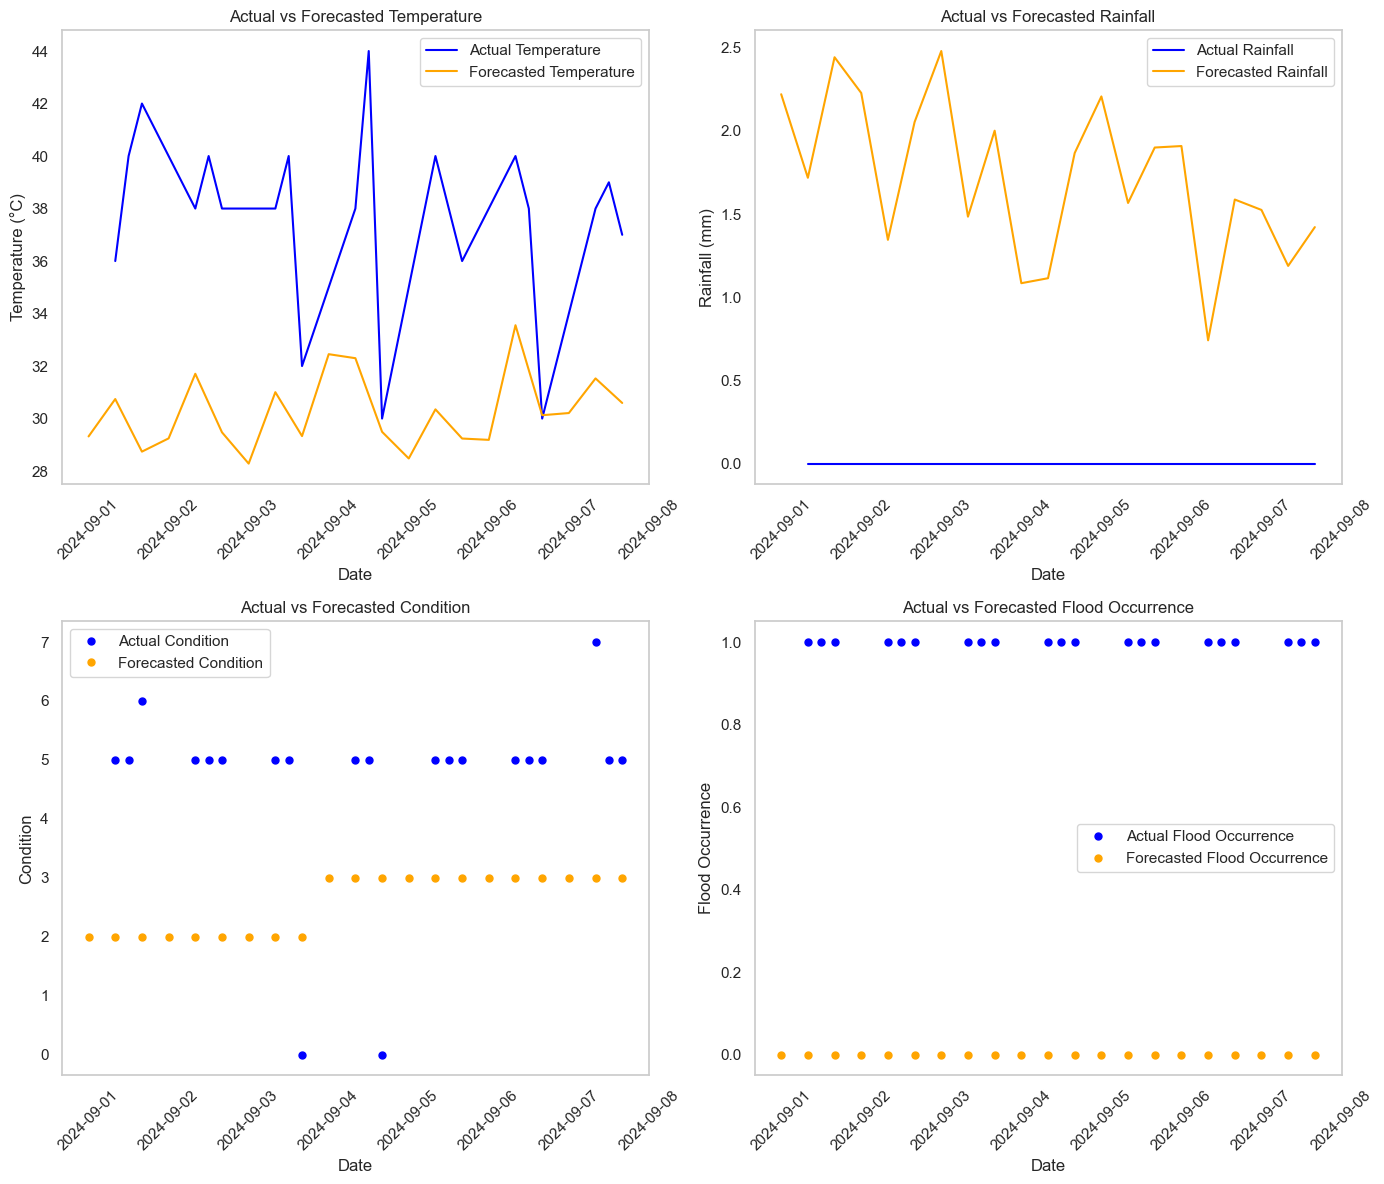

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the actual data from 'Actual.csv'
actual_data = pd.read_csv('Actual.csv')

# Check the columns of the actual data
print("Actual Data Columns:", actual_data.columns)

# Assuming forecast_df is already defined and contains the forecasted data
# For demonstration purposes, you may need to define it or load it from another source
# Example structure of forecast_df for context (replace this with actual loading code):
# forecast_df = pd.read_csv('Forecasted_Data.csv')  # Load your forecast data here
# print("Forecast Data Columns:", forecast_df.columns)

# Check the columns of the forecasted data
# print("Forecast Data Columns:", forecast_df.columns)

# Convert 'DATETIME' columns to datetime objects for proper plotting
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])

# Ensure forecast_df is defined and structured correctly
# Assuming forecast_df is defined with a proper structure
# forecast_df['DATETIME'] = pd.to_datetime(forecast_df['DATETIME'])

# Check if DATETIME column exists in forecast_df
if 'DATETIME' not in forecast_df.columns:
    print("Error: 'DATETIME' column not found in forecast_df")
else:
    forecast_df['DATETIME'] = pd.to_datetime(forecast_df['DATETIME'])

# Set the 'DATETIME' column as the index for both DataFrames
actual_data.set_index('DATETIME', inplace=True)
forecast_df.set_index('DATETIME', inplace=True)

# Create a figure with four subplots for each feature
plt.figure(figsize=(14, 12))

# Subplot 1: Temperature
plt.subplot(2, 2, 1)
plt.plot(actual_data.index, actual_data['TEMPERATURE (°C)'], label='Actual Temperature', color='blue')
plt.plot(forecast_df.index, forecast_df['TEMPERATURE (°C)'], label='Forecasted Temperature', color='orange')
plt.title('Actual vs Forecasted Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 2: Rainfall
plt.subplot(2, 2, 2)
plt.plot(actual_data.index, actual_data['RAINFALL (mm)'], label='Actual Rainfall', color='blue')
plt.plot(forecast_df.index, forecast_df['RAINFALL (mm)'], label='Forecasted Rainfall', color='orange')
plt.title('Actual vs Forecasted Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 3: Actual Condition
plt.subplot(2, 2, 3)
plt.plot(actual_data.index, actual_data['ACTUAL CONDITION'], label='Actual Condition', marker='o', linestyle='None', color='blue', markersize=5)
plt.plot(forecast_df.index, forecast_df['ACTUAL CONDITION'], label='Forecasted Condition', marker='o', linestyle='None', color='orange', markersize=5)
plt.title('Actual vs Forecasted Condition')
plt.xlabel('Date')
plt.ylabel('Condition')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 4: Occurrence of Flood
plt.subplot(2, 2, 4)
plt.plot(actual_data.index, actual_data['OCCURENCE OF FLOOD'], label='Actual Flood Occurrence', marker='o', linestyle='None', color='blue', markersize=5)
plt.plot(forecast_df.index, forecast_df['OCCURENCE OF FLOOD'], label='Forecasted Flood Occurrence', marker='o', linestyle='None', color='orange', markersize=5)
plt.title('Actual vs Forecasted Flood Occurrence')
plt.xlabel('Date')
plt.ylabel('Flood Occurrence')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
